In [1]:
import numpy as np
import numpy.ma as ma
from scipy.stats import norm, linregress
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.stats.mstats import theilslopes

In [2]:
#Creating Synthetic Data
def simulate_ar1(phi, sigma_tilde, n, zero_ends=False):
    """
    Simulates an AR(1) process.

    Parameters:
        phi (float): AR(1) coefficient.
        sigma_tilde (float): Standard deviation of noise.
        n (int): Length of the time series.
        zero_ends (bool): If True, modifies the process to zero the ends.

    Returns:
        numpy.ndarray: Simulated time series.
    """
    # Initialize the time series array
    y = np.zeros(n)
    
    # Generate noise from a standard normal distribution
    noise = norm.rvs(size=n)

    if zero_ends:
        n = n - 1  # Adjust the length
    else:
        # Set the first value of y
        y[0] = norm.rvs(scale=sigma_tilde / np.sqrt(1 - phi**2))

    # Simulate the AR(1) process
    for i in range(1, n):
        y[i] = phi * y[i - 1] + sigma_tilde * noise[i - 1]

    return y

def nlm(tlen, dt, dt_index, x0, p0, sigma, sin_model):
    def prop(x, p0):
        return -p0 + x - x**3
    x = np.zeros(tlen)
    x[0] = x0
    noise = sigma * np.random.randn(tlen)
    for i in range(tlen - 1):
        x[i + 1] = x[i] + prop(x[i], p0[i]) * dt + np.sqrt(dt) * noise[i]
        
    #Clip to reasonable level
    end_idx = int(np.where(x < 0)[0][0] - 2*365) #One half window size
        
    sin_component = get_sin(tlen, sin_model)
    #Add in a seasonal component
    x = x + sin_component
    
    #Get a version without seasonality
    x_perf = np.zeros(tlen)
    x_perf[0] = x0
    for i in range(tlen - 1):
        x_perf[i + 1] = x_perf[i] + prop(x_perf[i], p0[i]) * dt
    x_perf = x_perf + sin_component
    
    x = x / 2.5 #Modified to bring the data into quasi-NDVI space
    x_perf = x_perf / 2.5
    
    good = pd.Series(x[:end_idx], index=dt_index[:end_idx])
    s_half = pd.Series(x[end_idx:], index=dt_index[end_idx:])
    perf = pd.Series(x_perf[:end_idx], index=dt_index[:end_idx])
    return good, s_half, perf

def get_sin(tlen, sin_model):
    if sin_model == 'simple':
        return 0.5*np.sin(2*np.pi*np.arange(0,tlen,1)/365.25)
    
    elif sin_model == 'multiple':
        return 0.5*np.sin(2*np.pi*np.arange(0,tlen,1)/365.25) + 0.4*np.sin(2*np.pi*np.arange(0,tlen,1)/(365.25/2))
    
    elif sin_model == 'varying_amp':
        base_sin = 0.5*np.sin(2*np.pi*np.arange(0,tlen,1)/365.25)
        #Add randomly sized extra sin curve to each year
        extra_sin = np.zeros(tlen)
        for i in range(int(tlen/365.25)):
            i_0 = i*int(365.25)
            i_1 = (i+1) * int(365.25)
            if i_1 > tlen-1:
                i_1 = tlen
            extra_sin[i_0:i_1] = base_sin[i_0:i_1] + base_sin[i_0:i_1] * (np.random.randint(-5,5,1) / 50) #20
        return extra_sin
            
    elif sin_model == 'varying_timing':
        t = np.arange(0,tlen,1)/365.25
        base_sin = 0.5*np.sin(2*np.pi*t)
        shifted_sin = 0.5*np.sin(2*np.pi*t - np.pi/4)
        extra_sin = np.zeros(tlen)
        for i in range(int(tlen/365.25)):
            i_0 = i*int(365.25)
            i_1 = (i+1) * int(365.25)
            if i_1 > tlen-1:
                i_1 = tlen
            #phase_shift = np.random.randint(-1,1,1)
            #extra_sin[i_0:i_1] = 0.5*np.sin(2*np.pi*np.arange(0,tlen,1)/365.25 + phase_shift)[:365]
            extra_sin[i_0:i_1] = base_sin[i_0:i_1] + shifted_sin[i_0:i_1] * (np.random.randint(-5,5,1) / 50) #20
        return extra_sin
    
    elif sin_model == 'varying_amp_timing':
        t = np.arange(0,tlen,1)/365.25
        base_sin = 0.5*np.sin(2*np.pi*t)
        shifted_sin = 0.5*np.sin(2*np.pi*t - np.pi/4)
        extra_sin = np.zeros(tlen)
        for i in range(int(tlen/365.25)):
            i_0 = i*int(365.25)
            i_1 = (i+1) * int(365.25)
            if i_1 > tlen-1:
                i_1 = tlen
            extra_sin[i_0:i_1] = base_sin[i_0:i_1] + shifted_sin[i_0:i_1] * (np.random.randint(-5,5,1) / 50) + base_sin[i_0:i_1] * (np.random.randint(-5,5,1) / 50) #20
        return extra_sin
       
    elif sin_model == 'extra_noise':
        t = np.arange(0,tlen,1)/365.25
        base_sin = 0.5*np.sin(2*np.pi*t)
        extra_sin = np.zeros(tlen)
        increase = range(0,30)
        for i in range(int(tlen/365.25)):
            i_0 = i*int(365.25)
            i_1 = (i+1) * int(365.25)
            if i_1 > tlen-1:
                i_1 = tlen
            extra_sin[i_0:i_1] = base_sin[i_0:i_1] + np.random.randn(base_sin[i_0:i_1].shape[0])*(np.random.randint(-5,5,1) / 20)
        return extra_sin

In [51]:
#Adding Gaps/Outliers
def add_gaps_outliers(y, sigma_tilde, phi, n_gaps=50, n_outl=20):
    out = y.copy()
    n = y.shape[0]
    if n_gaps+n_outl > 0:
        points = np.random.choice(range(n), size=n_gaps+n_outl, replace=False)
        out[points[:n_gaps]] = np.nan
        out[points[n_gaps:n_gaps+n_outl]] = norm.rvs(scale=5*sigma_tilde / np.sqrt(1 - phi**2), size=n_outl)
    return out

def forced_gap(orig_ser, sample_pct=0, gap_months=[10,11,12,1,2,3,4,5]):
    ser = orig_ser.copy()

    #Add random gaps for cloud cover according to some percentage
    if sample_pct > 0:
        if sample_pct > 1:
            sample_pct = sample_pct / 100. #Can take percentage in either decimal or as parts of 100
        else:
            pass #sample_pct needs to be a percentage (e.g., 0.2)
        size = ser.shape[0]
        idx = np.random.choice(size, size=int(size*sample_pct), replace=False)
        ser[idx] = np.nan
        
    if gap_months:
        output = []
        #Choose random months to cover with snow or clouds, based on 'water year' of [Oct-Oct], defined by 'gap_months'
        for yr in np.unique(ser.index.year):
            #Split into water years
            idx_start = np.logical_and(ser.index.year == yr, ser.index.month >= 10)
            amin = ser.index[idx_start].min()
            idx_end = np.logical_and(ser.index.year == yr + 1, ser.index.month < 10)
            amax = ser.index[idx_end].max()
            wy = ser[amin:amax]
            
            for mo in gap_months:
                if mo < 10: #If we are at the next year already for winter gaps
                    idx = np.logical_and(wy.index.year == yr + 1, wy.index.month == mo)
                    wy[idx] = np.nan
                else:
                    idx = np.logical_and(wy.index.year == yr, wy.index.month == mo)
                    wy[idx] = np.nan
            output.append(wy)
            
        ser = pd.concat(output)
        ser = ser[ser.index.year > np.nanmin(ser.index.year)] #Drop first incomplete year
        #orig_ser = orig_ser[orig_ser.index.year > np.nanmin(orig_ser.index.year)]

    return ser

In [4]:
#Deseasoning/Detrending Functions
def fit_line2(x, y):
    import statsmodels.api as sm
    x = np.array(x).astype(float)
    X = sm.add_constant(x, prepend=True) #Add a column of ones to allow the calculation of the intercept
    model = sm.OLS(y, X, missing='drop').fit()
    intercept, slope = model.params
    pval = model.pvalues[1]

    return slope, pval, intercept

def detrend_flat(ser):
    x, y = ser.index, ser.values
    x = [(x - pd.Timestamp('1970-01-01')).days for x in x]
    m, p, b = fit_line2(x,y)
    y_ = m*np.array(x) + b
    y_fix = y - y_
    return y_fix

def daily_anomalies(ser):
    s = ser.groupby([ser.index.dayofyear], group_keys=False).apply(lambda x: x - x.mean())
    return s.sort_index()

def rolling_mean(ser, ws=120, min_per=None):
    if min_per:
        min_periods = min_per
    else:
        min_periods = ws-1
    return ser - ser.rolling(ws, center=True, min_periods=min_periods).apply(np.nanmean)

def runmean(x, w):
    n = x.shape[0]
    xs = np.zeros_like(x)
    for i in range(w // 2):
        xs[i] = np.nanmean(x[: i + w // 2 + 1])
    for i in range(n - w // 2, n):
        xs[i] = np.nanmean(x[i - w // 2 + 1:])
    for i in range(w // 2, n - w // 2):
        xs[i] = np.nanmean(x[i - w // 2 : i + w // 2 + 1])
    return x - xs

def harmonic_fit(ser, order=3):
    import statsmodels.api as sm
    harm_freq = list(range(1, order+1))
    
    x, y = ser.index, ser.values
    x = np.array([(x - pd.Timestamp('1970-01-01')).days for x in x]) / 365.25
    x_rad = x * 2 * np.pi #Convert days to radians for harmonic fitting
    
    #Create empty array to hold the independents
    nr_indep = order*2 + 2
    indep = np.empty((y.shape[0], nr_indep))
    
    #Add constant for intercept and then time
    indep[:,0] = 1
    indep[:,1] = x_rad
    
    #Now create the harmonic variables
    i = 2
    for freq in harm_freq:
        cos = np.cos(x_rad * freq)
        sin = np.sin(x_rad * freq)
        indep[:,i] = cos
        i = i + 1
        indep[:,i] = sin
        i = i + 1
        
    model = sm.OLS(y, indep, missing='drop').fit()
    coefs = model.params
    #print(coefs)
    fitted = []
    for t in range(x_rad.shape[0]):
        data = indep[t,:]
        harm_term = np.nansum(coefs*data)
        fitted.append(harm_term)
    fitted = np.array(fitted)
    return pd.Series(ser.values - fitted, index=ser.index)

def deseason_detrend(ser, yr=5, yl=23):
    rm_offline = pd.Series(runmean(ser.values, yr*yl), index=ser.index)
    deseason_rolling = harmonic_fit(rm_offline, order=3)
    return deseason_rolling

def robust_stl(ser, period, stl_settings='standard'):
    
    #Standard Settings
    seasonal_jump=1
    trend_jump=1 
    low_pass_jump=1
        
    if stl_settings == 'standard':
        #Can modify smoothing window as well as fitting degrees if curious
        smooth_length=7 
        seasonal_deg=1 
        trend_deg=1
        low_pass_deg=1
        
    from statsmodels.tsa.seasonal import STL
    def nt_calc(f,ns):
        '''Calcualte the length of the trend smoother based on
        Cleveland et al., 1990'''
        nt = (1.5*f)/(1-1.5*(1/ns)) + 1 #Force fractions to be rounded up
        if int(nt) % 2. == 1:
            return int(nt)
        elif int(nt) % 2. == 0:
            return int(nt) + 1
            
    def nl_calc(f):
        '''Calcualte the length of the low-pass filter based on
        Cleveland et al., 1990'''
        if int(f) % 2. == 1:
            return int(f) + 2
        elif int(f) % 2. == 0:
            return int(f) + 1
        
    res = STL(ser, period, seasonal=smooth_length, trend=nt_calc(period,smooth_length), low_pass=nl_calc(period), robust=True,\
              seasonal_deg=seasonal_deg, trend_deg=trend_deg, low_pass_deg=low_pass_deg, seasonal_jump=seasonal_jump,\
              trend_jump=trend_jump, low_pass_jump=low_pass_jump)#, ni, no)
    return res.fit()

In [5]:
#Computing CSD Metrics
def calc_ar1(x):
    #return np.corrcoef(x[:-1], x[1:])[0,1]
    return ma.corrcoef(ma.masked_invalid(x[:-1]), ma.masked_invalid(x[1:]))[0,1]

def compute_lam(x, dt=1):
    dx = (x[1:] - x[:-1]) / dt
    x0 = x[:-1]
    mask = ~np.isnan(x0) & ~np.isnan(dx)
    return linregress(x0[mask], dx[mask])[0]

def compute_sigma(x, dt=1):
    dx = (x[1:] - x[:-1]) / dt
    lamb = compute_lam(x, dt)
    diff = dx - lamb * x[:-1]
    return np.nanstd(diff) * np.sqrt(dt)

def estimate_lambda_ac1(X):
    lg = np.log(calc_ar1(X))
    if np.isnan(lg):
        lg = np.nan
    return lg

def estimate_lambda_var(X):
    sigma = compute_sigma(X)
    var = np.nanvar(X)
    rr_var = 0.5 * np.log(1-sigma**2 / var)
    if np.isnan(rr_var):
        rr_var = np.nan
    return rr_var

In [40]:
#Create Data with Seasonality
ds, de = pd.Timestamp('1991-06-01'), pd.Timestamp('2022-01-01')
dt_index = pd.date_range(ds, de-pd.Timedelta(days=1),freq='d')

np.random.seed(5000)
tlen = len(dt_index)
delta_t = 0.01
x0 = 0
sigma = 0.2
prange = np.linspace(-5, 1, tlen) #Modified for later tipping
#prange = np.linspace(-5, 5, tlen) #Original model

full_signal, s_half, perf = nlm(tlen, delta_t, dt_index, x0, prange, sigma, sin_model='simple')
ser = pd.concat([full_signal, s_half])
ser = ser.resample('SMS').mean()[36:] #Drop 18 months as 'spin up'
good_data = full_signal.resample('SMS').mean()[36:] #Drop 18 months as 'spin up'
perf_ds = full_signal - perf
perf_ds = perf_ds.resample('SMS').mean()[36:]
perf = perf.resample('SMS').mean()[36:]

yrs = 5 #5-year rolling for deseason
trim_len = 12*yrs #This is one half the 5-year rolling mean window (needs to be removed for harmonic and STL)
rm_offline = rolling_mean(good_data, yrs*24, min_per=1)
deseason_rolling = harmonic_fit(rm_offline)
deseason_rolling.values[:trim_len] = np.nan #Manually kill values that are less reliable
deseason_rolling.values[-trim_len:] = np.nan

In [62]:
#Create Data without Seasonality
_lambda = -4
phi = np.exp(_lambda)
sigma_tilde = 1
zero_ends = False

ds, de = pd.Timestamp('1991-06-01'), pd.Timestamp('2022-01-01')
dt_index = pd.date_range(ds, de-pd.Timedelta(days=1),freq='d')
n = len(dt_index)

ts0 = simulate_ar1(phi, sigma_tilde, n, zero_ends=zero_ends)
gap_ts0 = add_gaps_outliers(ts0, sigma_tilde, phi, n_gaps=int(0.7*tlen), n_outl=int(0.1*tlen))
ts0 = pd.Series(ts0, index=dt_index)
gap_ts0 = pd.Series(gap_ts0, index=dt_index)

Text(0.5, 1.0, 'Pure AR1')

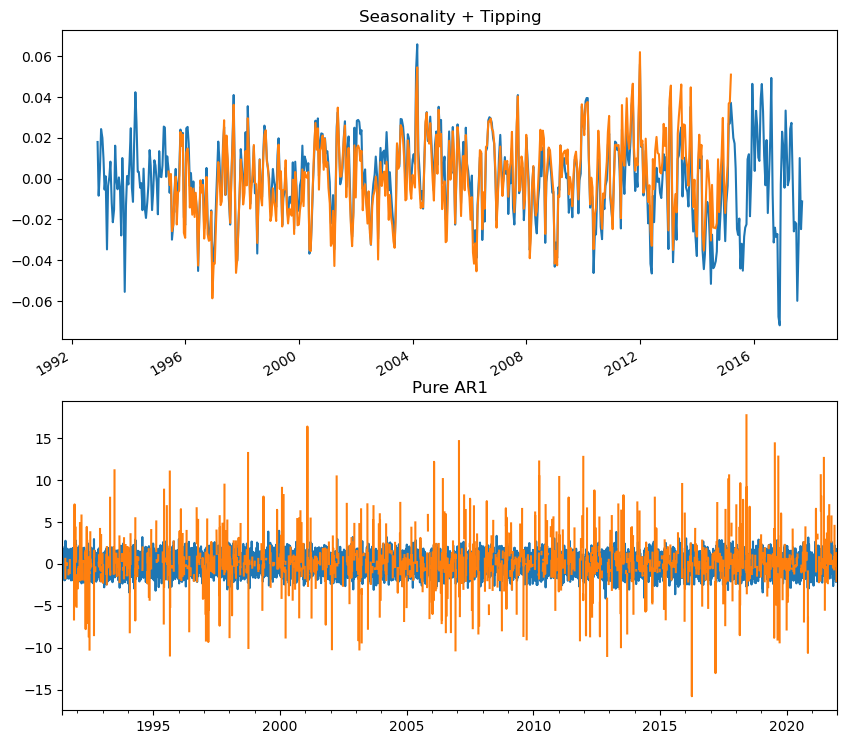

In [63]:
f, (ax, ax2) = plt.subplots(2, figsize=(10,10))
perf_ds.plot(ax=ax)
deseason_rolling.plot(ax=ax)
ax.set_title('Seasonality + Tipping')

ts0.plot(ax=ax2)
gap_ts0.plot(ax=ax2)
ax2.set_title('Pure AR1')

In [41]:
#Create 1000 simulations of each
def create_series(m=1000):
    ds, de = pd.Timestamp('1991-06-01'), pd.Timestamp('2022-01-01')
    dt_index = pd.date_range(ds, de-pd.Timedelta(days=1),freq='d')
    
    tlen = len(dt_index)
    delta_t = 0.01
    x0 = 0
    sigma = 0.2
    prange = np.linspace(-5, 1, tlen) #Modified for later tipping
    #prange = np.linspace(-5, 5, tlen) #Original model
    
    _lambda = -4
    phi = np.exp(_lambda)
    sigma_tilde = 1
    zero_ends = False
    
    p_ds, roll_ds, ar1_proc = [], [], []
    
    for i in range(m):
    
        np.random.seed(i)
        
        full_signal, s_half, perf = nlm(tlen, delta_t, dt_index, x0, prange, sigma, sin_model='simple')
        good_data = full_signal.resample('SMS').mean()[36:] #Drop 18 months as 'spin up'
        perf_ds = full_signal - perf
        perf_ds = perf_ds.resample('SMS').mean()[36:]

        yrs = 5 #5-year rolling for deseason
        trim_len = 12*yrs #This is one half the 5-year rolling mean window (needs to be removed for harmonic and STL)
        rm_offline = rolling_mean(good_data, yrs*24, min_per=1)
        deseason_rolling = harmonic_fit(rm_offline)
        deseason_rolling.values[:trim_len] = np.nan #Manually kill values that are less reliable
        deseason_rolling.values[-trim_len:] = np.nan
        
        n = len(dt_index)
        ts0 = simulate_ar1(phi, sigma_tilde, n, zero_ends=zero_ends)
        ts0 = pd.Series(ts0, index=dt_index)
        
        p_ds.append(perf_ds)
        roll_ds.append(deseason_rolling)
        ar1_proc.append(ts0)
        
    return p_ds, roll_ds, ar1_proc
        
p_ds, roll_ds, ar1_proc = create_series(1000)

In [56]:
def plot_lambdas(ser_list, ax):
    # Compute (lambda_AC1, lambda_Var) points
    points = [
        (estimate_lambda_ac1(X.values),
         estimate_lambda_var(X.values))
        for X in ser_list
    ]

    # Convert points to numpy array for easier manipulation
    points = np.array(points)

    # Define axis limits
    #min_ax = _lambda * 2
    min_ax = -8#np.nanmin(points[:, 0])
    max_ax = 0

    # Define the line for plotting
    line_points = np.arange(0.5 * np.log(1 / n) + 1e-10, max_ax, 0.01)
    line_curve = [0.5 * np.log(1 - n / (n - 1) * (1 - np.exp(2 * x))) for x in line_points]

    # Scatter plot
    ccoeff = ma.corrcoef(ma.masked_invalid(points[:,0]), ma.masked_invalid(points[:,1]))[0,1]
    ax.scatter(points[:, 0], points[:, 1], alpha=0.5, label="Simulated Points")
    ax.plot([min_ax, max_ax], [min_ax, max_ax], color="red", label="Identity Line")
    ax.plot(line_points, line_curve, color="blue", label="Theoretical Curve")
    ax.set_title('Corr: ' + str(ccoeff))

    # Set aspect ratio and limits
    ax.set_aspect('equal', 'box')
    ax.set_xlim(min_ax, max_ax)
    ax.set_ylim(min_ax, max_ax)
    ax.set_xlabel(r"$\lambda_{\mathrm{AC(1)}}$")
    ax.set_ylabel(r"$\lambda_{\mathrm{Var}}$")
    ax.legend()
    ax.grid(alpha=0.5)

/tmp/ipykernel_87712/505482166.py:27: RuntimeWarning: invalid value encountered in log
  rr_var = 0.5 * np.log(1-sigma**2 / var)
/tmp/ipykernel_87712/505482166.py:19: RuntimeWarning: invalid value encountered in log
  lg = np.log(calc_ar1(X))


(-1.0, 0.0)

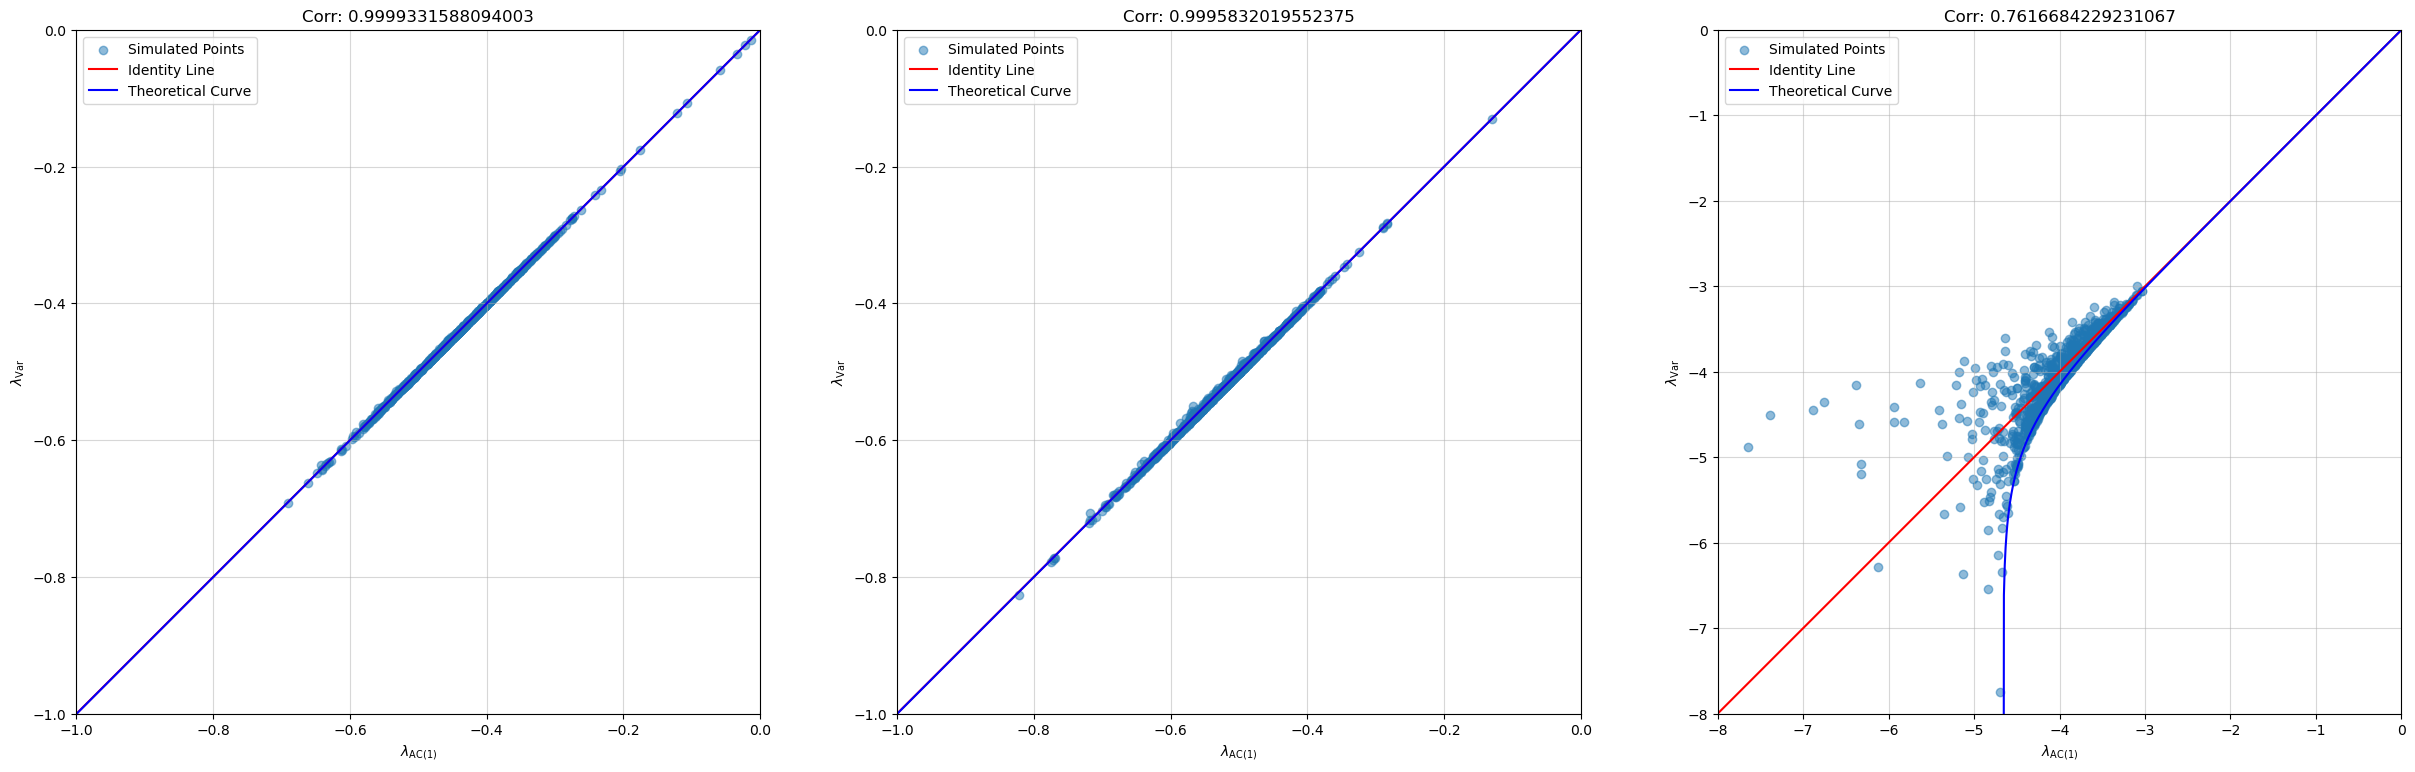

In [57]:
#Now estimate lambda for all series and plot (no gaps, no outliers)
f, (ax, ax2, ax3) = plt.subplots(1,3, figsize=(30,10))
plot_lambdas(p_ds, ax)
plot_lambdas(roll_ds, ax2)
plot_lambdas(ar1_proc, ax3)
ax.set_xlim(-1,0)
ax.set_ylim(-1,0)
ax2.set_xlim(-1,0)
ax2.set_ylim(-1,0)

/tmp/ipykernel_87712/505482166.py:27: RuntimeWarning: invalid value encountered in log
  rr_var = 0.5 * np.log(1-sigma**2 / var)
/tmp/ipykernel_87712/505482166.py:19: RuntimeWarning: invalid value encountered in log
  lg = np.log(calc_ar1(X))


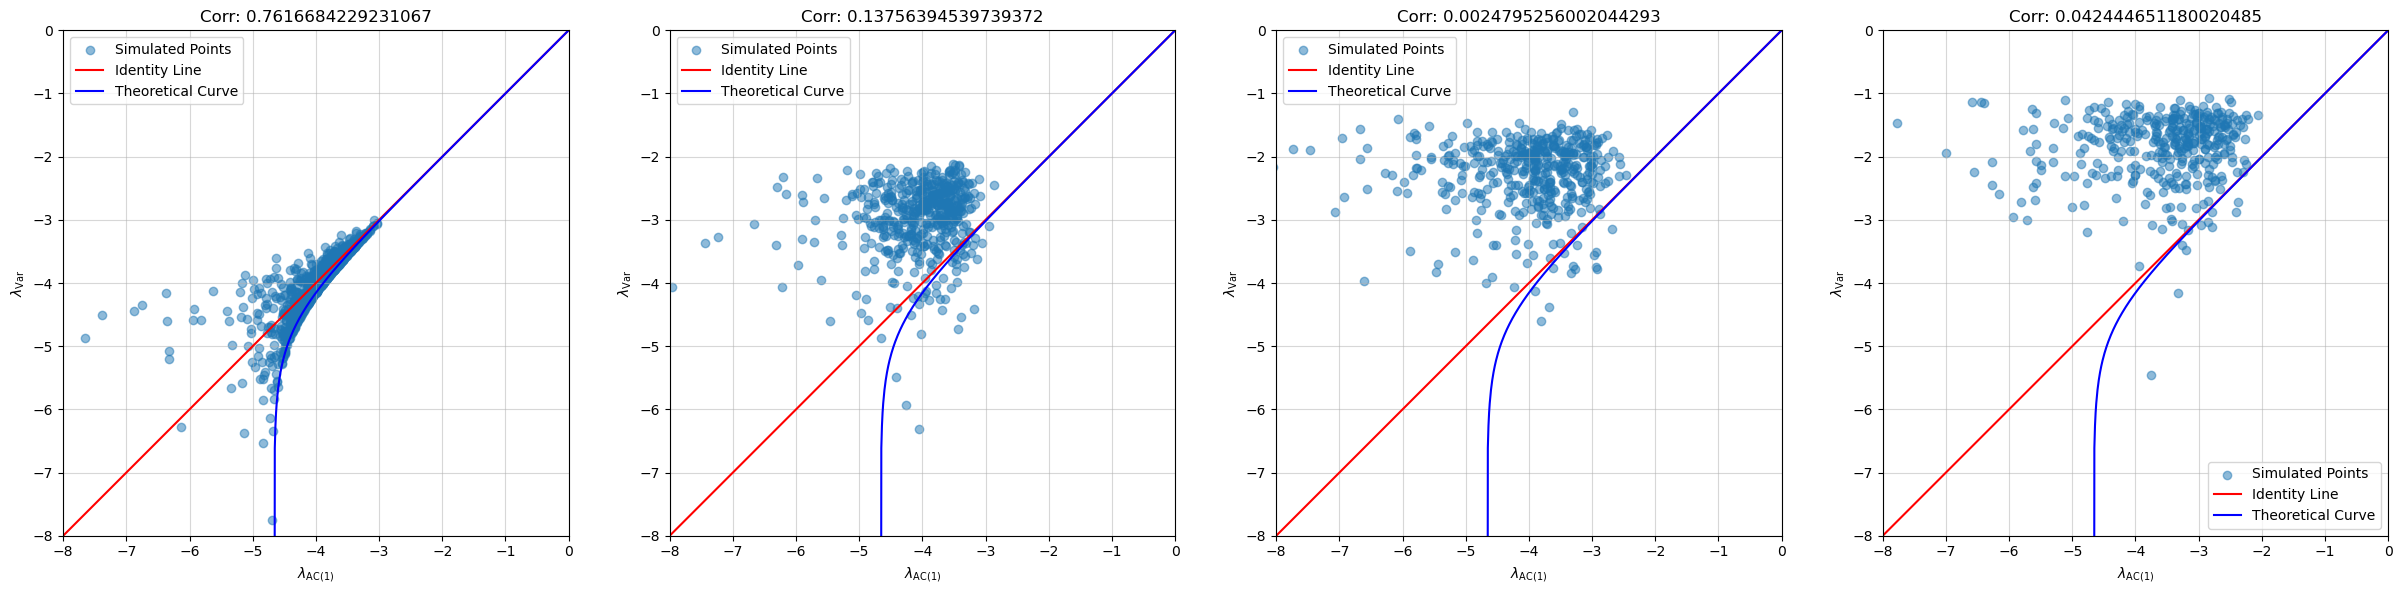

In [58]:
#Test adding gaps
_lambda = -4
phi = np.exp(_lambda)
sigma_tilde = 1
tlen = ar1_proc[0].shape[0]

gap_10 = [add_gaps_outliers(x, sigma_tilde, phi, n_gaps=int(0.1*tlen), n_outl=0) for x in ar1_proc] 
gap_50 = [add_gaps_outliers(x, sigma_tilde, phi, n_gaps=int(0.5*tlen), n_outl=0) for x in ar1_proc] 
gap_75 = [add_gaps_outliers(x, sigma_tilde, phi, n_gaps=int(0.75*tlen), n_outl=0) for x in ar1_proc] 

f, (ax, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(30,10))
plot_lambdas(ar1_proc, ax)
plot_lambdas(gap_10, ax2)
plot_lambdas(gap_50, ax3)
plot_lambdas(gap_75, ax4)

/tmp/ipykernel_87712/505482166.py:27: RuntimeWarning: invalid value encountered in log
  rr_var = 0.5 * np.log(1-sigma**2 / var)
/tmp/ipykernel_87712/505482166.py:19: RuntimeWarning: invalid value encountered in log
  lg = np.log(calc_ar1(X))


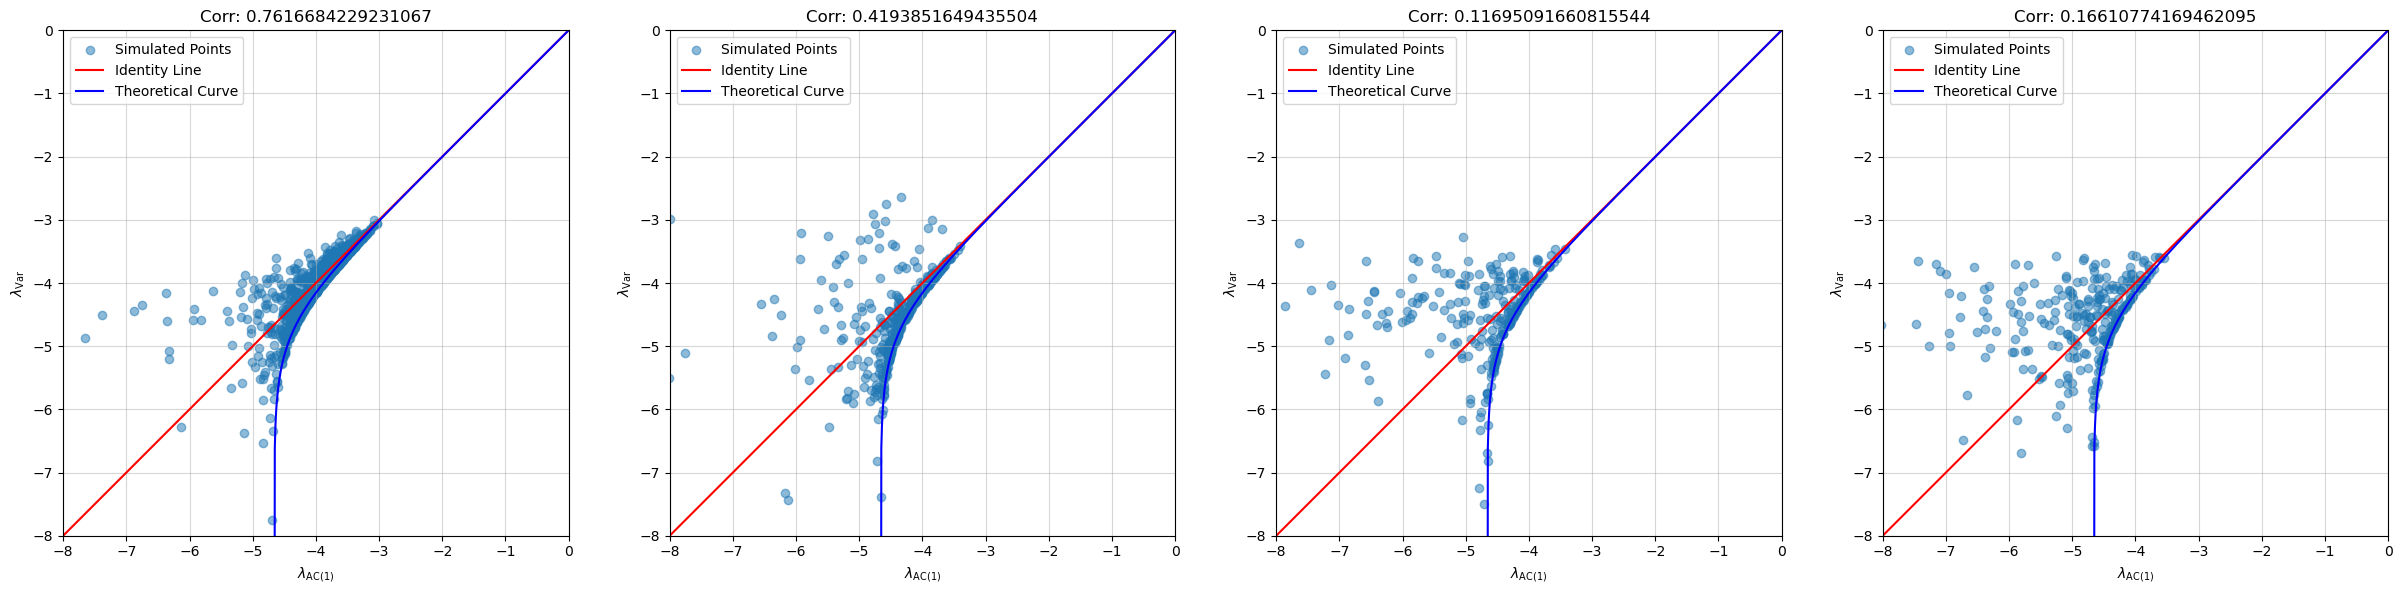

In [59]:
#Test adding outliers
_lambda = -4
phi = np.exp(_lambda)
sigma_tilde = 1
tlen = ar1_proc[0].shape[0]

out_10 = [add_gaps_outliers(x, sigma_tilde, phi, n_outl=int(0.1*tlen), n_gaps=0) for x in ar1_proc] 
out_50 = [add_gaps_outliers(x, sigma_tilde, phi, n_outl=int(0.5*tlen), n_gaps=0) for x in ar1_proc] 
out_75 = [add_gaps_outliers(x, sigma_tilde, phi, n_outl=int(0.75*tlen), n_gaps=0) for x in ar1_proc] 

f, (ax, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(30,10))
plot_lambdas(ar1_proc, ax)
plot_lambdas(out_10, ax2)
plot_lambdas(out_50, ax3)
plot_lambdas(out_75, ax4)

/tmp/ipykernel_87712/505482166.py:27: RuntimeWarning: invalid value encountered in log
  rr_var = 0.5 * np.log(1-sigma**2 / var)
/tmp/ipykernel_87712/505482166.py:19: RuntimeWarning: invalid value encountered in log
  lg = np.log(calc_ar1(X))


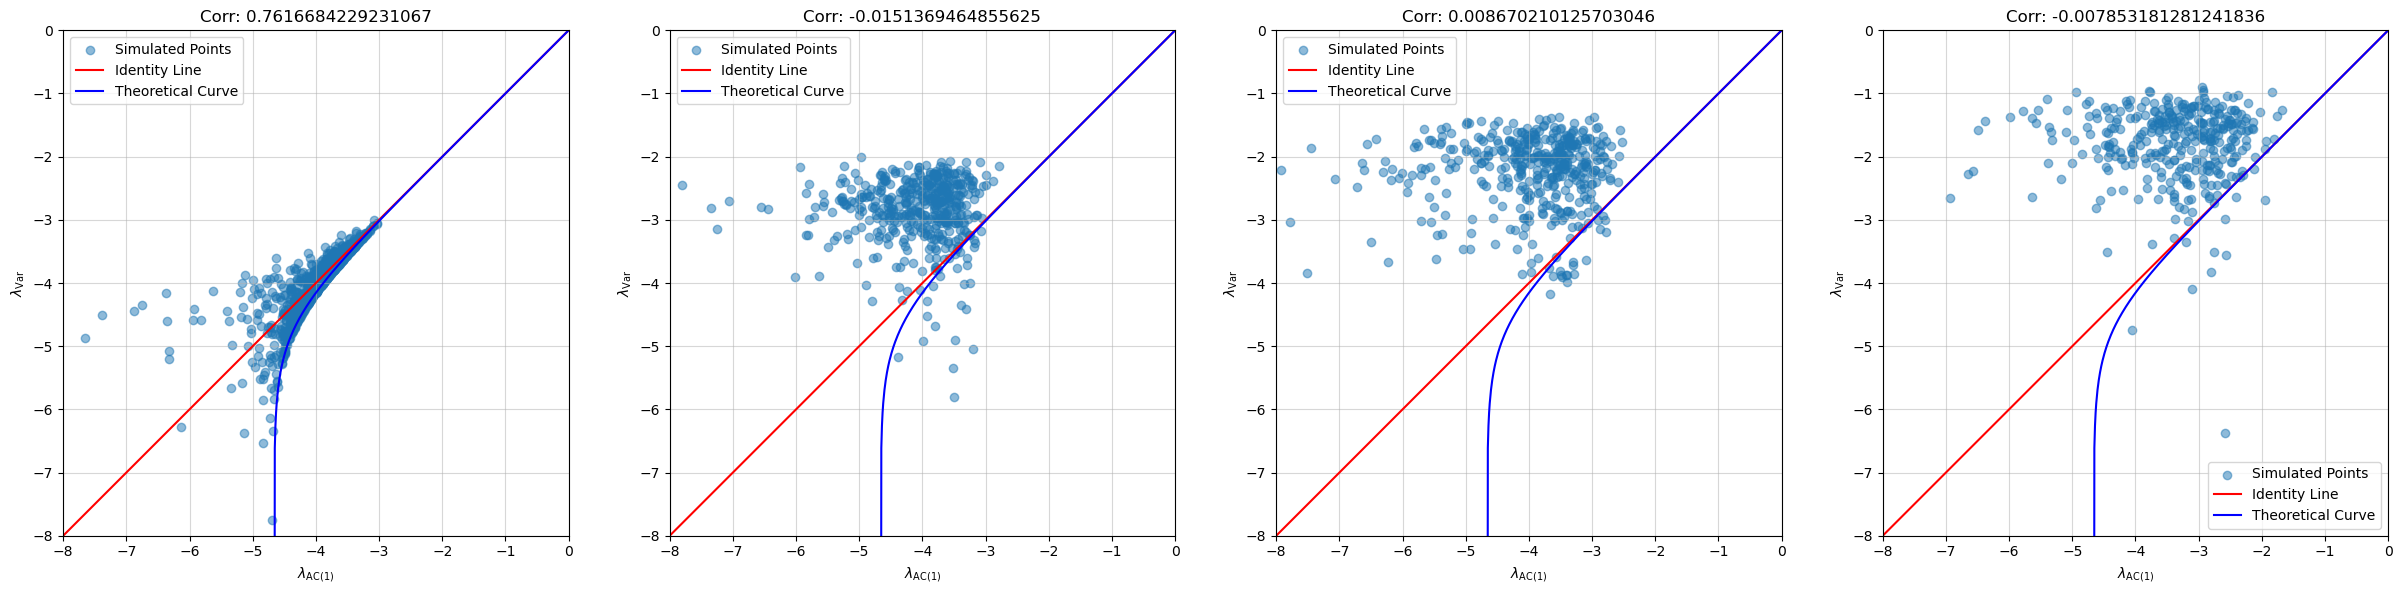

In [61]:
#Change shape of gaps (random gaps + longer winter gaps)
phi = np.exp(_lambda)
tlen = ar1_proc[0].shape[0]

gap_10 = [forced_gap(x, sample_pct=0.1, gap_months=[1,2,3]) for x in ar1_proc] 
gap_50 = [forced_gap(x, sample_pct=0.5, gap_months=[1,2,3]) for x in ar1_proc] 
gap_75 = [forced_gap(x, sample_pct=0.75, gap_months=[1,2,3]) for x in ar1_proc] 

f, (ax, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(30,10))
plot_lambdas(ar1_proc, ax)
plot_lambdas(gap_10, ax2)
plot_lambdas(gap_50, ax3)
plot_lambdas(gap_75, ax4)

/tmp/ipykernel_87712/505482166.py:27: RuntimeWarning: invalid value encountered in log
  rr_var = 0.5 * np.log(1-sigma**2 / var)
/tmp/ipykernel_87712/505482166.py:19: RuntimeWarning: invalid value encountered in log
  lg = np.log(calc_ar1(X))


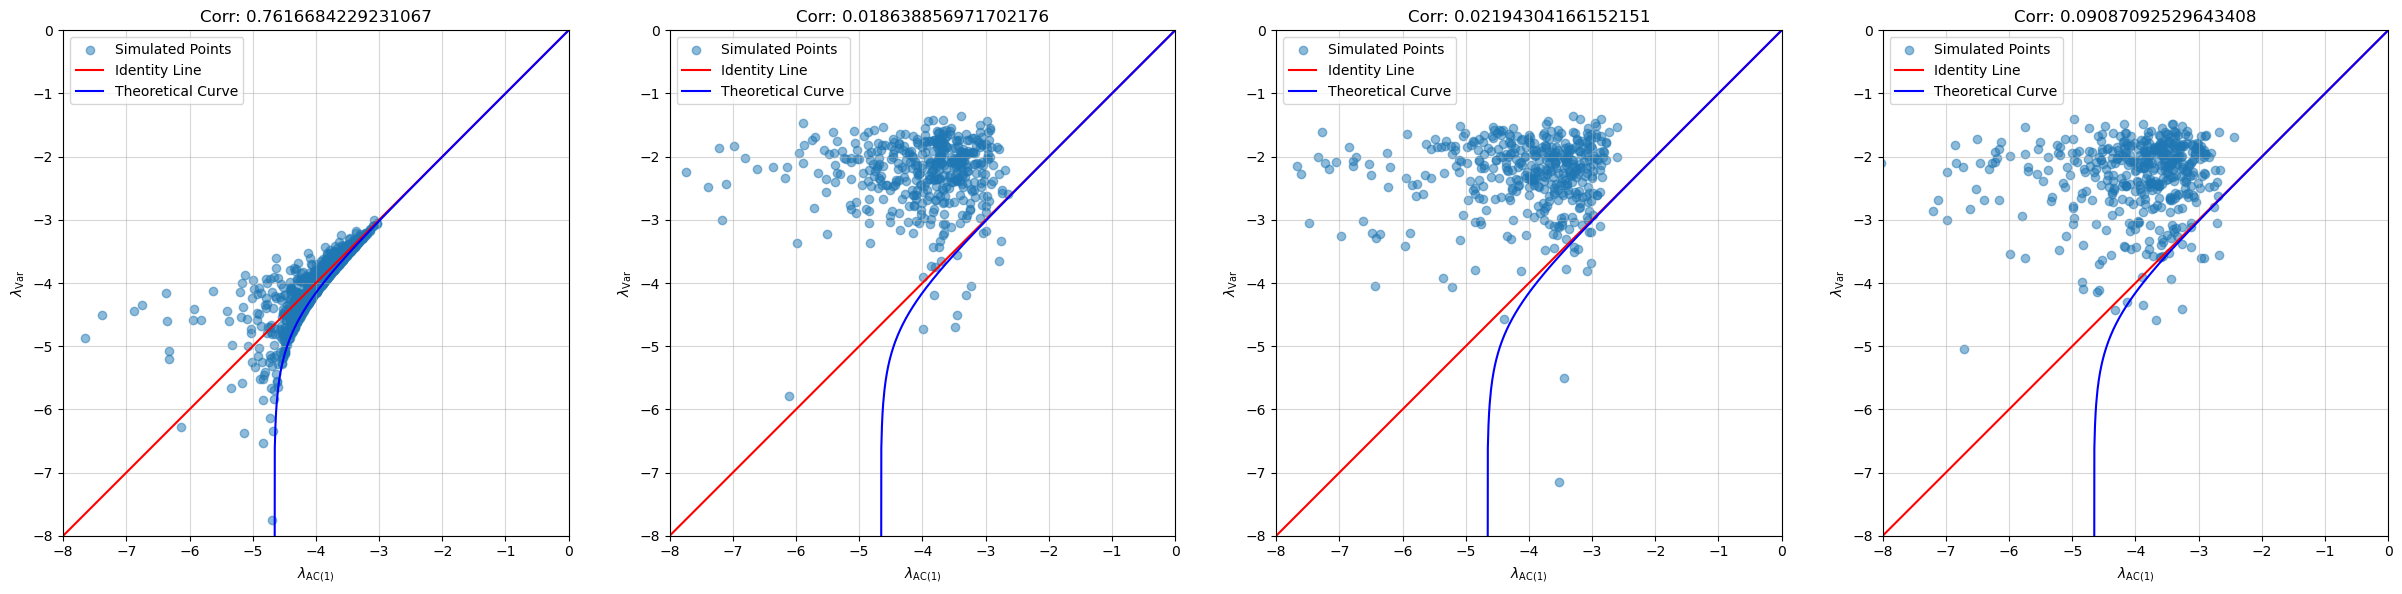

In [60]:
#Add gaps and change start time
_lambda = -4
phi = np.exp(_lambda)
sigma_tilde = 1
tlen = ar1_proc[0].shape[0]

gap_10 = [add_gaps_outliers(x, sigma_tilde, phi, n_gaps=int(0.5*tlen), n_outl=0)[5:] for x in ar1_proc] 
gap_50 = [add_gaps_outliers(x, sigma_tilde, phi, n_gaps=int(0.5*tlen), n_outl=0)[10:] for x in ar1_proc] 
gap_75 = [add_gaps_outliers(x, sigma_tilde, phi, n_gaps=int(0.5*tlen), n_outl=0)[25:] for x in ar1_proc] 

f, (ax, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(30,10))
plot_lambdas(ar1_proc, ax)
plot_lambdas(gap_10, ax2)
plot_lambdas(gap_50, ax3)
plot_lambdas(gap_75, ax4)

/var/folders/tz/fzy4bpxd7j54282vbs0hj3cm0000gn/T/ipykernel_64684/674474282.py:18: RuntimeWarning: invalid value encountered in log
  lg = np.log(calc_ar1(X))
/var/folders/tz/fzy4bpxd7j54282vbs0hj3cm0000gn/T/ipykernel_64684/674474282.py:26: RuntimeWarning: invalid value encountered in log
  rr_var = 0.5 * np.log(1-sigma**2 / var)


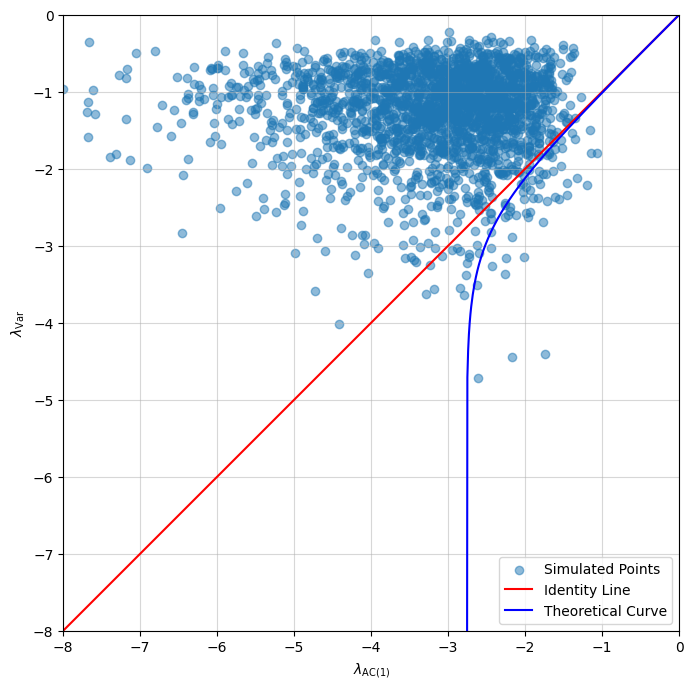

In [3]:
# Define parameters
_lambda = -4
phi = np.exp(_lambda)
sigma_tilde = 1
n = 250
m = 10000
zero_ends = False

# Simulate m time series using the AR(1) function
ts = [simulate_ar1(phi, sigma_tilde, n, zero_ends=zero_ends) for _ in range(m)]

# Compute (lambda_AC1, lambda_Var) points
points = [
    (estimate_lambda_ac1(X),
     estimate_lambda_var(X))
    for X in ts
]

# Convert points to numpy array for easier manipulation
points = np.array(points)

# Define axis limits
min_ax = _lambda * 2
max_ax = 0

# Define the line for plotting
line_points = np.arange(0.5 * np.log(1 / n) + 1e-10, max_ax, 0.01)
line_curve = [0.5 * np.log(1 - n / (n - 1) * (1 - np.exp(2 * x))) for x in line_points]

# Scatter plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(points[:, 0], points[:, 1], alpha=0.5, label="Simulated Points")
ax.plot([min_ax, max_ax], [min_ax, max_ax], color="red", label="Identity Line")
ax.plot(line_points, line_curve, color="blue", label="Theoretical Curve")

# Set aspect ratio and limits
ax.set_aspect('equal', 'box')
ax.set_xlim(min_ax, max_ax)
ax.set_ylim(min_ax, max_ax)
ax.set_xlabel(r"$\lambda_{\mathrm{AC(1)}}$")
ax.set_ylabel(r"$\lambda_{\mathrm{Var}}$")
ax.legend()
ax.grid(alpha=0.5)

plt.show()
